Internship Assignment

In [67]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, accuracy_score, classification_report,
                             mean_absolute_error, mean_squared_error)
import warnings
warnings.filterwarnings('ignore')

Loading Dataset

In [68]:
SENT_FILE = "./Data Files/fear_greed_index.csv"
TRADES_FILE = "./Data Files/historical_data.csv"
DATE_COL_SENT = "date"                          # from fear_greed_index.csv
SENT_COL = "classification"                     # values: 'Fear' or 'Greed' from fear_greed_index.csv
TIME_COL_TRADES = "Timestamp IST"               # timestamp for each trade
PNL_COL = "Closed PnL"                          # realized PnL for a trade/event
SIZE_COL = "Size USD"                           # trade size in USD
SIDE_COL = "Side"                               # 'buy'/'sell' or similar
ACCOUNT_COL = "Account"                         # trader identifier
SYMBOL_COL = "Coin"                             # filter to BTC or similar if dataset has many pairs

# csv files loading
sent = pd.read_csv(SENT_FILE)
trades = pd.read_csv(TRADES_FILE)

In [69]:
# Checking Loaded Data
print("Sentiment data columns:", sent.columns.tolist())
print("Trades data columns:", trades.columns.tolist())
print("Sentiment data sample:")
print(sent.head())
print("Trades data sample:")
print(trades.head())

Sentiment data columns: ['timestamp', 'value', 'classification', 'date']
Trades data columns: ['Account', 'Coin', 'Execution Price', 'Size Tokens', 'Size USD', 'Side', 'Timestamp IST', 'Start Position', 'Direction', 'Closed PnL', 'Transaction Hash', 'Order ID', 'Crossed', 'Fee', 'Trade ID', 'Timestamp']
Sentiment data sample:
    timestamp  value classification        date
0  1517463000     30           Fear  2018-02-01
1  1517549400     15   Extreme Fear  2018-02-02
2  1517635800     40           Fear  2018-02-03
3  1517722200     24   Extreme Fear  2018-02-04
4  1517808600     11   Extreme Fear  2018-02-05
Trades data sample:
                                      Account  Coin  Execution Price  \
0  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9769   
1  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9800   
2  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9855   
3  0xae5eacaf9c6b9111fd53034a602c192a04e082ed  @107           7.9874   
4  0

Basic Cleaning

In [70]:
# Sentiment: parse date - use 'date' column from fear_greed_index.csv
sent[DATE_COL_SENT] = pd.to_datetime(sent[DATE_COL_SENT]).dt.normalize()
sent['sentiment'] = sent[SENT_COL].str.lower().map({'greed':1, 'fear':0, 'extreme greed':1, 'extreme fear':0})
if sent['sentiment'].isnull().any():
    # handle other labels or typos
    sent['sentiment'] = sent[SENT_COL].str.lower().apply(lambda x: 1 if 'greed' in str(x) else (0 if 'fear' in str(x) else np.nan))
sent = sent.sort_values(DATE_COL_SENT).reset_index(drop=True)

# Trades: parse timestamp with correct format (dd-mm-yyyy HH:MM)
print("Sample timestamps from trades data:")
print(trades[TIME_COL_TRADES].head())

# Parse timestamp with dayfirst=True for dd-mm-yyyy format
try:
    trades[TIME_COL_TRADES] = pd.to_datetime(trades[TIME_COL_TRADES], dayfirst=True, errors='coerce')
    # Check for any failed parses
    if trades[TIME_COL_TRADES].isnull().any():
        print(f"Warning: {trades[TIME_COL_TRADES].isnull().sum()} timestamps could not be parsed")
        print("Problematic timestamps:")
        print(trades[trades[TIME_COL_TRADES].isnull()][TIME_COL_TRADES].head())
except Exception as e:
    print(f"Error parsing timestamps: {e}")
    # Try alternative approach
    trades[TIME_COL_TRADES] = pd.to_datetime(trades[TIME_COL_TRADES], format='mixed', dayfirst=True, errors='coerce')

trades['date'] = trades[TIME_COL_TRADES].dt.normalize()

# Filter for Bitcoin trades only
if SYMBOL_COL in trades.columns:
    print("Unique coins in trades data:", trades[SYMBOL_COL].unique())
    trades['symbol_clean'] = trades[SYMBOL_COL].astype(str).str.upper().str.strip()
    # Check if there are any BTC trades
    btc_trades = trades[trades['symbol_clean'].str.contains('BTC', na=False)]
    if len(btc_trades) > 0:
        print(f"Filtering BTC trades: {len(btc_trades)} out of {len(trades)} total trades")
        trades = btc_trades.copy()
    else:
        print("No BTC trades found, using all trades")
        # Create a dummy BTC column for analysis
        trades['is_btc'] = False

# Clean numeric columns - handle potential commas and other non-numeric characters
for c in [PNL_COL, SIZE_COL]:
    if c in trades.columns:
        # Convert to string first to handle any non-numeric values
        trades[c] = trades[c].astype(str)
        # Remove commas and other non-numeric characters except decimal point and minus sign
        trades[c] = trades[c].str.replace(',', '').str.replace('$', '').str.replace(' ', '')
        trades[c] = pd.to_numeric(trades[c], errors='coerce')
        
# Clean execution price
if 'Execution Price' in trades.columns:
    trades['Execution Price'] = trades['Execution Price'].astype(str)
    trades['Execution Price'] = trades['Execution Price'].str.replace(',', '').str.replace('$', '').str.replace(' ', '')
    trades['execution_price'] = pd.to_numeric(trades['Execution Price'], errors='coerce')
    
# Remove rows with invalid timestamps
initial_count = len(trades)
trades = trades.dropna(subset=[TIME_COL_TRADES]).reset_index(drop=True)
print(f"After cleaning: {len(trades)} trades remaining (removed {initial_count - len(trades)} rows with invalid timestamps)")

Sample timestamps from trades data:
0    02-12-2024 22:50
1    02-12-2024 22:50
2    02-12-2024 22:50
3    02-12-2024 22:50
4    02-12-2024 22:50
Name: Timestamp IST, dtype: object
Unique coins in trades data: ['@107' 'AAVE' 'DYDX' 'AIXBT' 'GMX' 'EIGEN' 'HYPE' 'SOL' 'SUI' 'DOGE'
 'ETH' 'kPEPE' 'TRUMP' 'ONDO' 'ENA' 'LINK' 'XRP' 'S' 'BNB' 'BERA' 'WIF'
 'LAYER' 'MKR' 'KAITO' 'IP' 'JUP' 'USUAL' 'ADA' 'BTC' 'PURR/USDC' 'ZRO'
 '@7' '@19' '@21' '@44' '@48' '@11' '@15' '@46' '@61' '@28' '@45' '@9'
 '@41' '@38' 'kSHIB' 'GRASS' 'TAO' 'AVAX' '@2' '@6' '@8' '@10' '@12' '@16'
 '@17' '@35' '@26' '@24' '@32' '@29' '@31' '@33' '@34' '@36' '@37' '@47'
 '@53' '@74' 'RUNE' 'CANTO' 'NTRN' 'BLUR' 'ZETA' 'MINA' 'MANTA' 'RNDR'
 'WLD' 'kBONK' 'ALT' 'INJ' 'STG' 'ZEN' 'MAVIA' 'PIXEL' 'ILV' 'FET' 'STRK'
 'CAKE' 'STX' 'ACE' 'PENDLE' 'AR' 'XAI' 'APE' 'MEME' 'NEAR' 'SEI' 'FTM'
 'MYRO' 'BIGTIME' 'IMX' 'BADGER' 'POLYX' 'OP' 'TNSR' 'MAV' 'TIA' 'MERL'
 'TON' 'PURR' 'ME' 'CRV' 'BRETT' 'CHILLGUY' 'MOODENG' 'VIRTUAL' 'COM

Feature engineering

In [71]:
# Daily aggregates function
def daily_aggregates(df):
    g = df.groupby('date')
    daily = pd.DataFrame({
        'trade_count': g.size(),
        'unique_accounts': g[ACCOUNT_COL].nunique() if ACCOUNT_COL in df.columns else g.size(),
        'total_volume': g[SIZE_COL].sum() if SIZE_COL in df.columns else np.nan,
        'avg_trade_size': g[SIZE_COL].mean() if SIZE_COL in df.columns else np.nan,
        'net_realized_pnl': g[PNL_COL].sum() if PNL_COL in df.columns else np.nan,
        'mean_realized_pnl': g[PNL_COL].mean() if PNL_COL in df.columns else np.nan,
    }).reset_index()
    return daily

daily = daily_aggregates(trades)
print(f"Daily aggregates computed for {len(daily)} days")

# Compute win rate per day: fraction of positive closedPnL trades
if PNL_COL in trades.columns:
    win = trades.assign(win=trades[PNL_COL] > 0).groupby('date')['win'].mean().reset_index().rename(columns={'win':'win_rate'})
    daily = daily.merge(win, on='date', how='left')

# Add volatility proxy: intraday price std if you have price column
if 'execution_price' in trades.columns:
    price_vol = trades.groupby('date')['execution_price'].std().reset_index().rename(columns={'execution_price':'price_std'})
    daily = daily.merge(price_vol, on='date', how='left')
else:
    # Use PnL std as volatility proxy
    pnl_vol = trades.groupby('date')[PNL_COL].std().reset_index().rename(columns={PNL_COL:'pnl_std'})
    daily = daily.merge(pnl_vol, on='date', how='left')

# Add buy/sell ratio
if SIDE_COL in trades.columns:
    print("Unique sides in trades:", trades[SIDE_COL].unique())
    side_counts = trades.groupby(['date', SIDE_COL]).size().unstack(fill_value=0)
    print("Side counts columns:", side_counts.columns.tolist())
    
    # Handle different possible side labels
    buy_cols = [col for col in side_counts.columns if 'buy' in str(col).lower() or 'long' in str(col).lower()]
    sell_cols = [col for col in side_counts.columns if 'sell' in str(col).lower() or 'short' in str(col).lower()]
    
    if buy_cols and sell_cols:
        buy_col = buy_cols[0]
        sell_col = sell_cols[0]
        side_counts['buy_sell_ratio'] = side_counts[buy_col] / (side_counts[sell_col] + 0.001)  # avoid division by zero
        daily = daily.merge(side_counts[['buy_sell_ratio']], on='date', how='left')
    else:
        print("Could not identify clear buy/sell columns")

Daily aggregates computed for 286 days
Unique sides in trades: ['BUY' 'SELL']
Side counts columns: ['BUY', 'SELL']


In [72]:
# Final daily data check

# Merge with sentiment 
print("Daily columns before merge:", daily.columns.tolist())
print("Sentiment columns before merge:", sent.columns.tolist())

# Merge keeping the date column from daily
df = pd.merge(daily, sent[[DATE_COL_SENT,'sentiment']], left_on='date', right_on=DATE_COL_SENT, how='inner')
# Don't drop the date column - we need it for plotting
print("Columns after merge:", df.columns.tolist())

print(f"After merging with sentiment: {len(df)} days with both trade and sentiment data")
print("Date ranges:")
print(f"Trades: {trades['date'].min()} to {trades['date'].max()}")
print(f"Sentiment: {sent[DATE_COL_SENT].min()} to {sent[DATE_COL_SENT].max()}")

# Check if we have the date column
if 'date' not in df.columns:
    if DATE_COL_SENT in df.columns:
        df['date'] = df[DATE_COL_SENT]
    else:
        print("Warning: No date column found in merged data")

Daily columns before merge: ['date', 'trade_count', 'unique_accounts', 'total_volume', 'avg_trade_size', 'net_realized_pnl', 'mean_realized_pnl', 'win_rate', 'price_std', 'buy_sell_ratio']
Sentiment columns before merge: ['timestamp', 'value', 'classification', 'date', 'sentiment']
Columns after merge: ['date', 'trade_count', 'unique_accounts', 'total_volume', 'avg_trade_size', 'net_realized_pnl', 'mean_realized_pnl', 'win_rate', 'price_std', 'buy_sell_ratio', 'sentiment']
After merging with sentiment: 286 days with both trade and sentiment data
Date ranges:
Trades: 2023-12-05 00:00:00 to 2025-05-01 00:00:00
Sentiment: 2018-02-01 00:00:00 to 2025-05-02 00:00:00


Exploratory plots

Available columns for plotting: ['date', 'trade_count', 'unique_accounts', 'total_volume', 'avg_trade_size', 'net_realized_pnl', 'mean_realized_pnl', 'win_rate', 'price_std', 'buy_sell_ratio', 'sentiment']


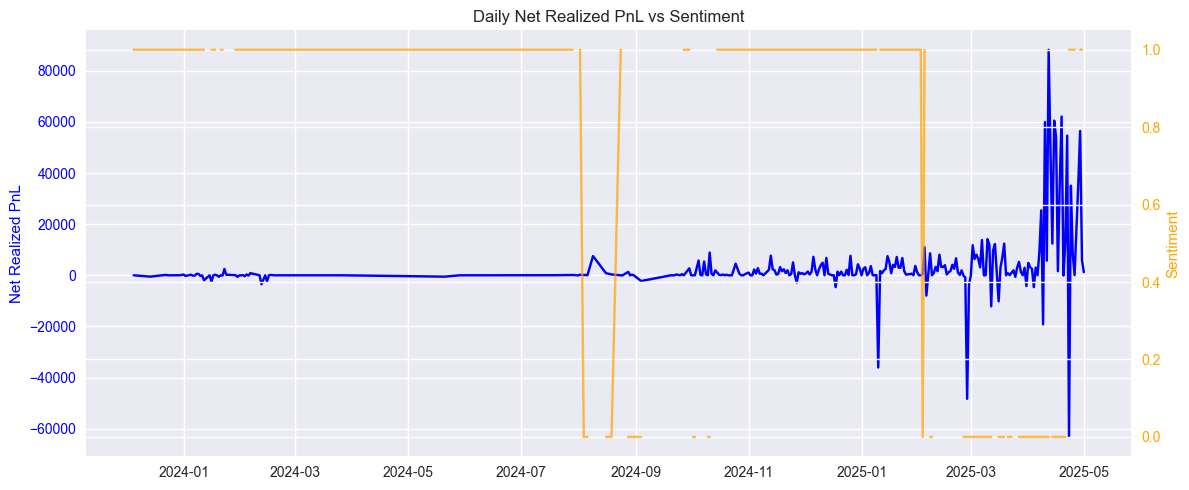

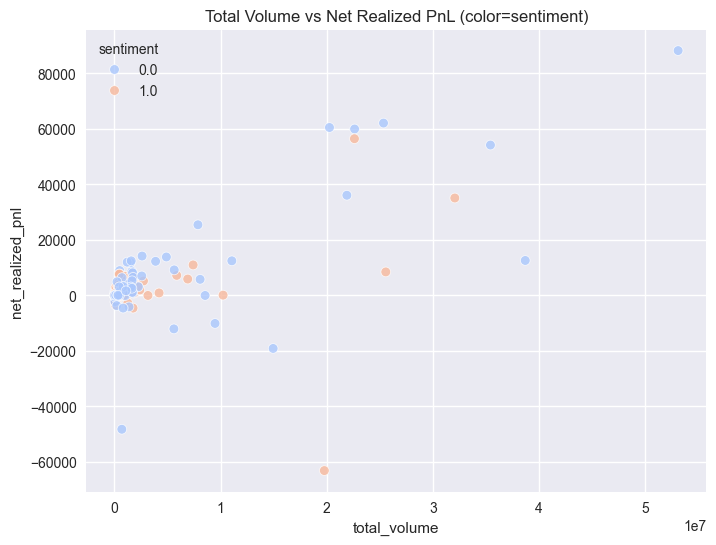

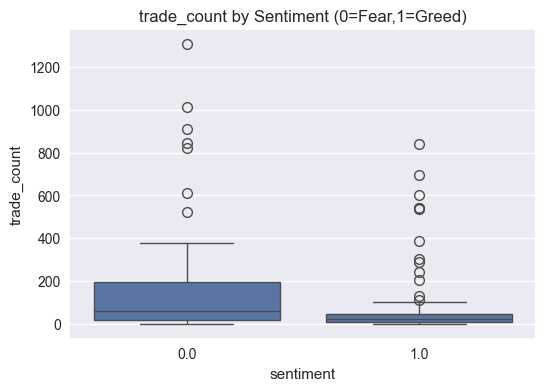

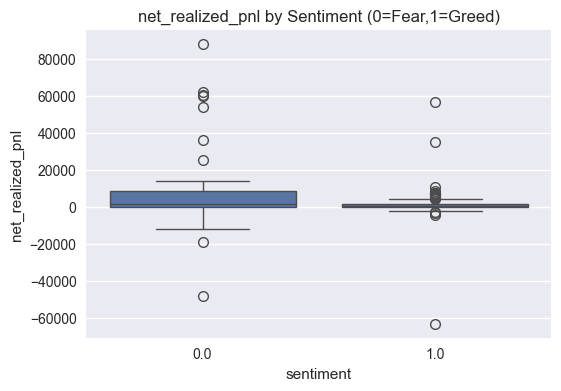

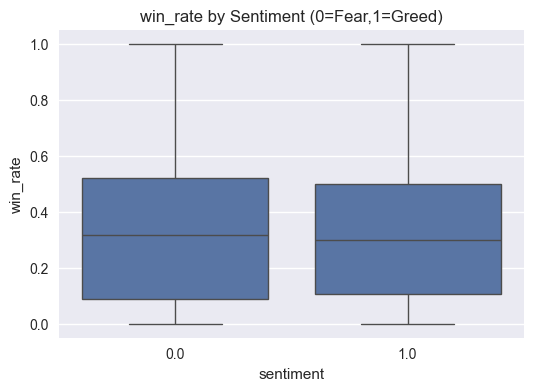

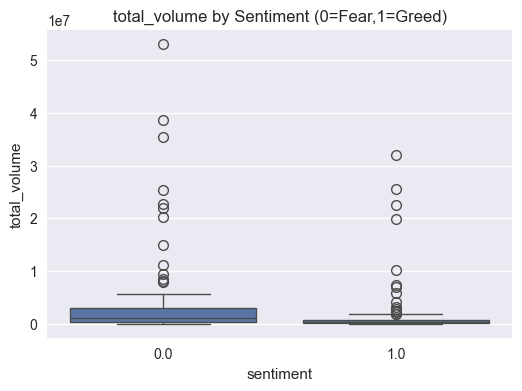

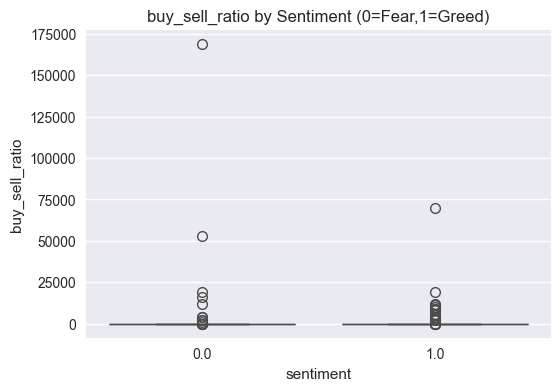

Correlation matrix with sentiment:
                   sentiment
sentiment           1.000000
mean_realized_pnl  -0.007039
win_rate           -0.040264
buy_sell_ratio     -0.107931
price_std          -0.167644
net_realized_pnl   -0.215936
avg_trade_size     -0.246853
total_volume       -0.260196
trade_count        -0.282164
unique_accounts    -0.433067
Greed days: 171, Fear days: 68
T-test net_realized_pnl: t=-2.431, p=0.0174, mean_greed=1265.251, mean_fear=7142.742
T-test trade_count: t=-3.380, p=0.0011, mean_greed=56.585, mean_fear=171.103
T-test win_rate: t=-0.604, p=0.5468, mean_greed=0.312, mean_fear=0.335
T-test total_volume: t=-2.991, p=0.0038, mean_greed=1217436.917, mean_fear=4965642.450
T-test buy_sell_ratio: t=-1.130, p=0.2625, mean_greed=1160.006, mean_fear=4149.969
Cohen's d for net_realized_pnl: -0.488
Cohen's d for trade_count: -0.649
Cohen's d for win_rate: -0.089
Cohen's d for total_volume: -0.595
Cohen's d for buy_sell_ratio: -0.240
Correlations for net_realized_pnl wi

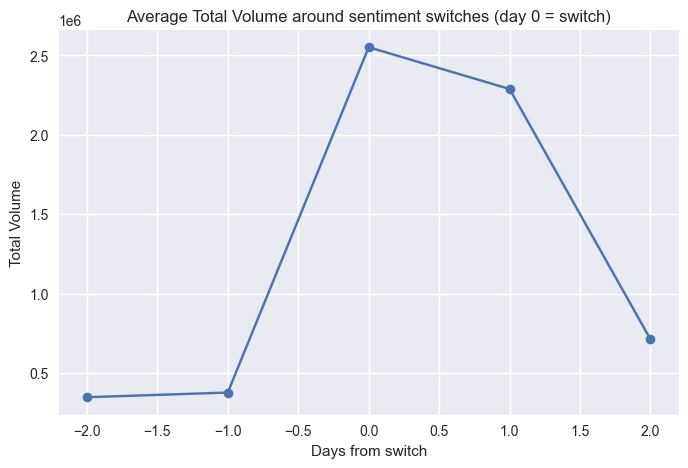

Toy model: next-day pnl sign prediction
accuracy: 0.7931034482758621
              precision    recall  f1-score   support

           0       0.25      0.10      0.14        10
           1       0.83      0.94      0.88        48

    accuracy                           0.79        58
   macro avg       0.54      0.52      0.51        58
weighted avg       0.73      0.79      0.75        58

Output saved: daily_aggregates_with_sentiment.csv
Output saved: per_account_summary.csv
Analysis complete!


In [73]:
# Visualizations
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12,5)

if len(df) > 0 and 'date' in df.columns:
    print("Available columns for plotting:", df.columns.tolist())
    
    # Time series: net_realized_pnl vs sentiment
    if 'net_realized_pnl' in df.columns and 'sentiment' in df.columns:
        fig, ax1 = plt.subplots()
        ax1.plot(df['date'], df['net_realized_pnl'], label='Net Realized PnL', color='blue')
        ax1.set_ylabel('Net Realized PnL', color='blue')
        ax1.tick_params(axis='y', labelcolor='blue')
        
        ax2 = ax1.twinx()
        ax2.plot(df['date'], df['sentiment'], color='orange', alpha=0.7, label='Sentiment (Greed=1,Fear=0)')
        ax2.set_ylabel('Sentiment', color='orange')
        ax2.tick_params(axis='y', labelcolor='orange')
        
        ax1.set_title('Daily Net Realized PnL vs Sentiment')
        fig.tight_layout()
        plt.show()

    # Scatter: total_volume vs net_realized_pnl colored by sentiment
    plt.figure(figsize=(8,6))
    if 'total_volume' in df.columns and 'net_realized_pnl' in df.columns and 'sentiment' in df.columns:
        sns.scatterplot(data=df, x='total_volume', y='net_realized_pnl', hue='sentiment', alpha=0.8, palette='coolwarm')
        plt.title('Total Volume vs Net Realized PnL (color=sentiment)')
        plt.show()

    # Boxplots: trade metrics split by sentiment
    for col in ['trade_count','net_realized_pnl','win_rate','total_volume', 'buy_sell_ratio']:
        if col in df.columns:
            plt.figure(figsize=(6,4))
            sns.boxplot(x='sentiment', y=col, data=df)
            plt.title(f'{col} by Sentiment (0=Fear,1=Greed)')
            plt.show()

    # ---------- Correlations & simple tests ----------
    # Pearson correlation
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    if 'sentiment' in numeric_cols:
        corr = df[numeric_cols].corr()
        print("Correlation matrix with sentiment:")
        print(corr[['sentiment']].sort_values('sentiment', ascending=False))

    # T-test: compare metrics in greed vs fear days
    from scipy.stats import ttest_ind
    if 'sentiment' in df.columns:
        greed_rows = df[df['sentiment']==1]
        fear_rows = df[df['sentiment']==0]
        
        print(f"Greed days: {len(greed_rows)}, Fear days: {len(fear_rows)}")
        
        for col in ['net_realized_pnl','trade_count','win_rate','total_volume', 'buy_sell_ratio']:
            if col in df.columns:
                g = greed_rows[col].dropna()
                f = fear_rows[col].dropna()
                if len(g)>1 and len(f)>1:
                    t, p = ttest_ind(g, f, equal_var=False)
                    print(f"T-test {col}: t={t:.3f}, p={p:.4f}, mean_greed={g.mean():.3f}, mean_fear={f.mean():.3f}")

    # Effect size (Cohen's d)
    def cohens_d(a,b):
        na, nb = len(a), len(b)
        sa, sb = a.std(), b.std()
        pooled = np.sqrt(((na-1)*sa**2 + (nb-1)*sb**2) / (na+nb-2))
        return (a.mean()-b.mean())/pooled

    if 'sentiment' in df.columns and len(greed_rows) > 0 and len(fear_rows) > 0:
        for col in ['net_realized_pnl','trade_count','win_rate','total_volume', 'buy_sell_ratio']:
            if col in df.columns:
                d = cohens_d(greed_rows[col].dropna(), fear_rows[col].dropna())
                print(f"Cohen's d for {col}: {d:.3f}")

    # ---------- Lagged correlations ----------
    # Create lagged sentiment columns and correlate with metrics
    if 'sentiment' in df.columns:
        for lag in range(1,4):  
            df[f'sent_lag_{lag}'] = df['sentiment'].shift(lag)
        
        for col in ['net_realized_pnl','trade_count','win_rate','total_volume', 'buy_sell_ratio']:
            if col in df.columns:
                corrs = []
                for lag in range(1,4):
                    c = df[[col, f'sent_lag_{lag}']].corr().iloc[0,1]
                    corrs.append((lag,c))
                print(f"Correlations for {col} with previous sentiment lags:", corrs)

    # ---------- Regression: predict high volume days from sentiment ----------
    # Create binary label: high_volume_day (top 25% total_volume)
    if 'total_volume' in df.columns and 'sentiment' in df.columns and len(df) > 10:
        df['high_volume_day'] = (df['total_volume'] >= df['total_volume'].quantile(0.75)).astype(int)
        X = df[['sentiment']].fillna(0)
        y = df['high_volume_day']
        
        if len(X) > 10:
            split_point = int(0.8 * len(X))
            X_train, X_test = X[:split_point], X[split_point:]
            y_train, y_test = y[:split_point], y[split_point:]
            
            if len(y_test) > 0 and len(np.unique(y_test)) > 1:
                clf = LogisticRegression()
                clf.fit(X_train, y_train)
                preds = clf.predict(X_test)
                print("Logistic Regression (predict high volume day from sentiment)")
                print("coef:", clf.coef_, "intercept:", clf.intercept_)
                print("accuracy:", accuracy_score(y_test,preds))
                print("roc_auc:", roc_auc_score(y_test, clf.predict_proba(X_test)[:,1]))

    # ---------- Trader-level segmentation ----------
    # Build per-account aggregates
    if ACCOUNT_COL in trades.columns and len(trades) > 0:
        acct = trades.groupby(ACCOUNT_COL).agg({
            SIZE_COL: 'sum',
            PNL_COL: ['sum','mean','std'],
            TIME_COL_TRADES: 'count'
        })
        # flatten columns
        acct.columns = ['_'.join(col).strip() for col in acct.columns.values]
        acct = acct.reset_index().rename(columns={
            f"{TIME_COL_TRADES}_count": "trade_count"
        })
        # Compute Sharpe-like metric (mean/std)
        acct['pnl_sharpe'] = acct[f'{PNL_COL}_mean'] / (acct[f'{PNL_COL}_std'].replace(0,np.nan))
        acct = acct.fillna(0)

        print(f"Per-account analysis: {len(acct)} unique accounts")

        # clustering: scale and cluster
        features = ['trade_count', f'{SIZE_COL}_sum', f'{PNL_COL}_sum']
        feat = acct[features].fillna(0)
        if len(feat) > 3:  # need enough accounts for clustering
            scaler = StandardScaler()
            Xs = scaler.fit_transform(feat)
            kmeans = KMeans(n_clusters=min(3, len(feat)), random_state=42).fit(Xs)
            acct['cluster'] = kmeans.labels_

            # Show cluster summaries
            print("Cluster summary (per-account):")
            print(acct.groupby('cluster')[features].mean())

    # ---------- Event study: behavior around sentiment switches ----------
    # find dates where sentiment changes (0->1 or 1->0)
    if 'sentiment' in sent.columns and len(sent) > 1:
        sent_changes = sent.copy()
        sent_changes['prev'] = sent_changes['sentiment'].shift(1)
        sent_changes['change'] = sent_changes['sentiment'] - sent_changes['prev']
        switches = sent_changes[sent_changes['change']!=0][[DATE_COL_SENT,'prev','sentiment','change']].dropna()
        print(f"Found {len(switches)} sentiment switches")

        # For each switch, compute average metric window [-2,+2] days (smaller window)
        window = 2
        event_rows = []
        for idx, row in switches.iterrows():
            d = row[DATE_COL_SENT]
            window_range = pd.date_range(d - pd.Timedelta(days=window), d + pd.Timedelta(days=window))
            sub = df.set_index('date').reindex(window_range).reset_index()
            sub['day_offset'] = range(-window, window+1)
            sub['switch_date'] = d
            event_rows.append(sub)
        
        if event_rows:
            events_df = pd.concat(event_rows, ignore_index=True)
            # compute mean across events
            event_avg = events_df.groupby('day_offset').mean(numeric_only=True).reset_index()
            
            if 'total_volume' in event_avg.columns:
                plt.figure(figsize=(8,5))
                plt.plot(event_avg['day_offset'], event_avg['total_volume'], marker='o')
                plt.title('Average Total Volume around sentiment switches (day 0 = switch)')
                plt.xlabel('Days from switch')
                plt.ylabel('Total Volume')
                plt.grid(True)
                plt.show()

    # ---------- Simple strategy idea demonstration ----------
    # Build a toy model: predict sign(next-day net_realized_pnl) using today's sentiment and metrics
    if all(col in df.columns for col in ['net_realized_pnl', 'sentiment', 'total_volume', 'trade_count', 'win_rate']) and len(df) > 20:
        df['pnl_sign_next'] = np.sign(df['net_realized_pnl'].shift(-1)).fillna(0)
        features = ['sentiment','total_volume','trade_count','win_rate']
        X = df[features].fillna(0)
        y = (df['pnl_sign_next']>0).astype(int)
        
        if len(X) > 20:
            split_point = int(0.8 * len(X))
            X_train, X_test = X[:split_point], X[split_point:]
            y_train, y_test = y[:split_point], y[split_point:]
            
            if len(y_test) > 0 and len(np.unique(y_test)) > 1:
                clf2 = LogisticRegression(max_iter=500)
                clf2.fit(X_train, y_train)
                preds = clf2.predict(X_test)
                print("Toy model: next-day pnl sign prediction")
                print("accuracy:", accuracy_score(y_test,preds))
                print(classification_report(y_test,preds))

else:
    print("No overlapping data between trades and sentiment datasets")

# ---------- Saving outputs ----------
if len(df) > 0:
    df.to_csv("daily_aggregates_with_sentiment.csv", index=False)
    print("Output saved: daily_aggregates_with_sentiment.csv")
    
if 'acct' in locals() and len(acct) > 0:
    acct.to_csv("per_account_summary.csv", index=False)
    print("Output saved: per_account_summary.csv")

print("Analysis complete!")